In [82]:
import numpy as np

# Start at 0, end at 100, generate 1000 points
x = np.linspace(0, 100, 1000)
y = np.sin(x)
n = 5

y_multi = np.repeat(y[:, None], n, axis=1)   # or np.tile(y[:, None], (1, n))


print(x.shape)
print(y.shape)
print(y_multi.shape)

print("y_multi sample:", y_multi[:5])

y = y_multi  # Use the multi-dimensional version for further processing

(1000,)
(1000,)
(1000, 5)
y_multi sample: [[0.         0.         0.         0.         0.        ]
 [0.09993302 0.09993302 0.09993302 0.09993302 0.09993302]
 [0.19886554 0.19886554 0.19886554 0.19886554 0.19886554]
 [0.29580708 0.29580708 0.29580708 0.29580708 0.29580708]
 [0.3897871  0.3897871  0.3897871  0.3897871  0.3897871 ]]


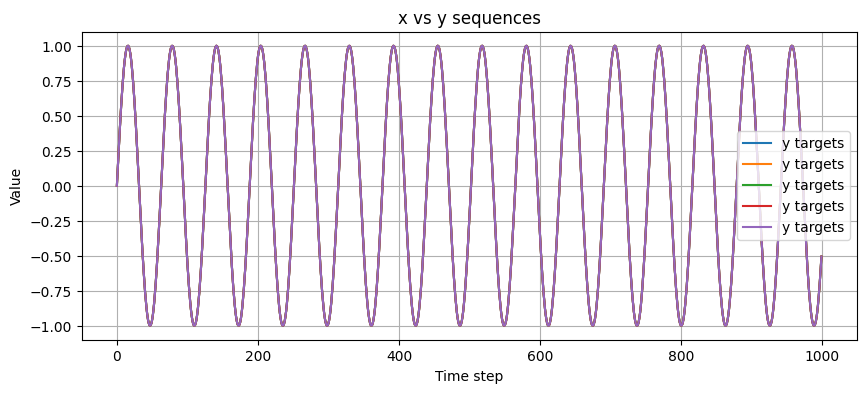

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# x, y can be PyTorch tensors; convert if needed:
x_np = np.asarray(x)
y_np = np.asarray(y)

plt.figure(figsize=(10, 4))
#plt.plot(x_np, label='x inputs')
plt.plot(y_np, label='y targets')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('x vs y sequences')
plt.legend()
plt.grid(True)
plt.show()


In [84]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    
    # We loop until we hit the end of the data minus the window size
    for i in range(len(data) - window_size):
        
        # 1. Input: The sequence from 'i' to 'i + window_size'
        seq = data[ i : i + window_size ] 
        
        # 2. Target: The single value at 'i + window_size'
        label = data[ i + window_size ]
        
        sequences.append(seq)
        targets.append(label)
        
    return np.array(sequences), np.array(targets)

In [85]:
input_seq, target_seq = create_sequences(y, window_size=50)
print("Input sequence shape:", input_seq.shape)
print("Target sequence shape:", target_seq.shape)

Input sequence shape: (950, 50, 5)
Target sequence shape: (950, 5)


In [86]:
import torch
seqs = torch.from_numpy(input_seq).float()
targets = torch.from_numpy(target_seq).float()

#seqs = seqs.unsqueeze(-1)  # Add feature dimension

print("Input sequences tensor shape:", seqs.shape)
print("Target sequences tensor shape:", targets.shape)

Input sequences tensor shape: torch.Size([950, 50, 5])
Target sequences tensor shape: torch.Size([950, 5])


In [87]:
import torch.nn as nn

class SineLSTM(nn.Module):
    def __init__(self, input_size=n, hidden_size=60, output_size=n):
        super(SineLSTM, self).__init__()
        
        # 1. Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 2. Define the Linear layer (Head)
        self.linear = nn.Linear(60, output_size)

    def forward(self, x):
        # 1. Pass data through LSTM
        # out shape: (batch_size, sequence_length, hidden_size)
        out, _ = self.lstm(x)

        #print("LSTM output shape:", out.shape)
        
        # 2. Select the hidden state from the LAST time step
        # We want all batches (:), the last time step (-1), and all features (:)
        last_time_step_out = out[:, -1, :]
        
        # 3. Pass that summary to the Linear layer to get the prediction
        prediction = self.linear(last_time_step_out)
        
        return prediction

In [88]:
# 1. Instantiate the model
model = SineLSTM()

# 2. Pass your input data through the model
# Note: This uses the random weights (untrained), so the output values will be garbage.
# We just care about the SHAPE right now.
output = model(seqs)

print("Final Output shape:", output.shape)

Final Output shape: torch.Size([950, 5])


In [89]:
model = SineLSTM()


# 1. Define Loss
criterion = nn.MSELoss()

# 2. Define Optimizer
# We pass it the model's parameters so it knows WHAT to adjust.
# 'lr' is the learning rate (step size). 0.001 is a safe starting point.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. Number of times to loop through the data
epochs = 100

# Set model to training mode (good practice)
model.train()

print("Training started...")

for i in range(epochs):
    
    # --- STEP 1: Forward Pass ---
    # Make predictions for the whole batch
    y_pred = model(seqs)
    #print("y_pred shape:", y_pred.shape)
    y_pred = y_pred.mean(dim=1, keepdim=True)  # -> shape [950, 1]
    #print("y_pred shape after sum:", y_pred.shape)
    #print("targets shape:", targets.shape)
    # --- STEP 2: Calculate Loss ---
    # Compare prediction (y_pred) vs real value (targets)
    loss = criterion(y_pred, targets)
    
    # --- STEP 3: Zero Gradients ---
    # Clear the buffer
    optimizer.zero_grad()
    
    # --- STEP 4: Backward Pass ---
    # Calculate the gradients (backpropagation)
    loss.backward()
    
    # --- STEP 5: Optimizer Step ---
    # Update the weights
    optimizer.step()
    
    # Print progress every 10 epochs
    if i % 10 == 0:
        print(f'Epoch: {i} | Loss: {loss.item():.5f}')

print("Training complete!")

Training started...
Epoch: 0 | Loss: 0.50312


/home/limin/Documents/programming/gemini-lstm-next-frame-prediction/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([950, 5])) that is different to the input size (torch.Size([950, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10 | Loss: 0.37393
Epoch: 20 | Loss: 0.19333
Epoch: 30 | Loss: 0.10142
Epoch: 40 | Loss: 0.04532
Epoch: 50 | Loss: 0.01455
Epoch: 60 | Loss: 0.00345
Epoch: 70 | Loss: 0.00230
Epoch: 80 | Loss: 0.00083
Epoch: 90 | Loss: 0.00046
Training complete!


predicted_tensor shape: torch.Size([950, 5])
predicted_tensor sample: tensor([[-0.8500, -1.0508, -0.9944, -0.9126, -0.9793],
        [-0.8199, -1.0247, -0.9566, -0.8813, -0.9541],
        [-0.7824, -0.9894, -0.9090, -0.8391, -0.9216],
        [-0.7375, -0.9448, -0.8518, -0.7861, -0.8819],
        [-0.6851, -0.8907, -0.7852, -0.7223, -0.8348]])
predicted_tensor shape after mean: torch.Size([950, 1])
predicted_tensor sample after mean: tensor([[-0.9574],
        [-0.9273],
        [-0.8883],
        [-0.8404],
        [-0.7836]])
predicted_signal shape: (950, 1)
real_signal sample: [[-0.95749253 -0.95749253 -0.95749253 -0.95749253 -0.95749253]
 [-0.923873   -0.923873   -0.923873   -0.923873   -0.923873  ]
 [-0.881004   -0.881004   -0.881004   -0.881004   -0.881004  ]
 [-0.8293146  -0.8293146  -0.8293146  -0.8293146  -0.8293146 ]
 [-0.76932245 -0.76932245 -0.76932245 -0.76932245 -0.76932245]]
predicted_signal sample: [[-0.9574149 ]
 [-0.92729455]
 [-0.8883246 ]
 [-0.84044904]
 [-0.7836126

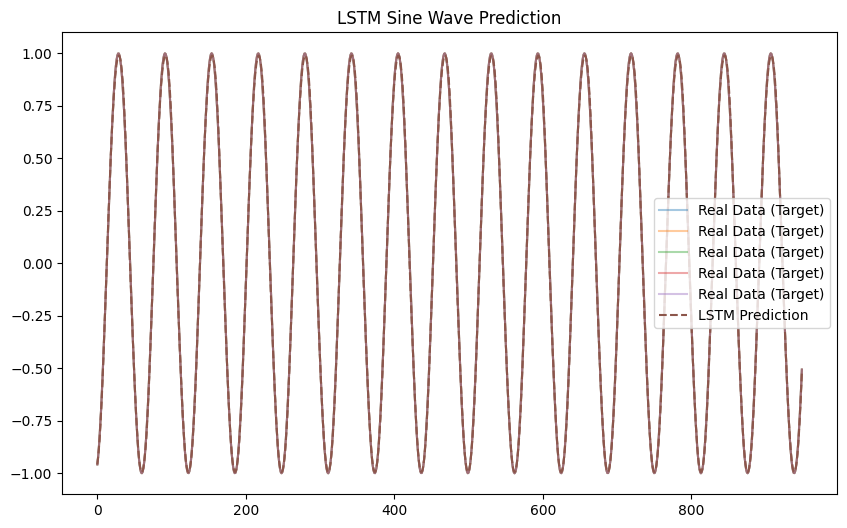

In [90]:
import matplotlib.pyplot as plt

# 1. Set model to evaluation mode (turns off features like Dropout)
model.eval()

# 2. Make predictions on the whole dataset
with torch.no_grad(): # Tells PyTorch "don't calculate gradients", which speeds this up
    predicted_tensor = model(seqs)
    print("predicted_tensor shape:", predicted_tensor.shape)
    print("predicted_tensor sample:", predicted_tensor[:5])
    predicted_tensor = predicted_tensor.mean(dim=1, keepdim=True)   # shape [950, 1]
    print("predicted_tensor shape after mean:", predicted_tensor.shape)
    print("predicted_tensor sample after mean:", predicted_tensor[:5])



# 3. Convert back to NumPy for plotting
# .detach() removes it from the graph, .numpy() converts it
predicted_signal = predicted_tensor.detach().numpy()
real_signal = targets.detach().numpy()
#print("real_signal shape:", real_signal.shape)
print("predicted_signal shape:", predicted_signal.shape)
print("real_signal sample:", real_signal[:5])
print("predicted_signal sample:", predicted_signal[:5])
# 4. Plot!
plt.figure(figsize=(10,6))
plt.plot(real_signal, label='Real Data (Target)', alpha=0.4)
plt.plot(predicted_signal, label='LSTM Prediction', linestyle='--')
plt.title('LSTM Sine Wave Prediction')
plt.legend()
plt.show()

Multivariate Input

Input Data Shape: (1000, 2)
Target Data Shape: (1000,)


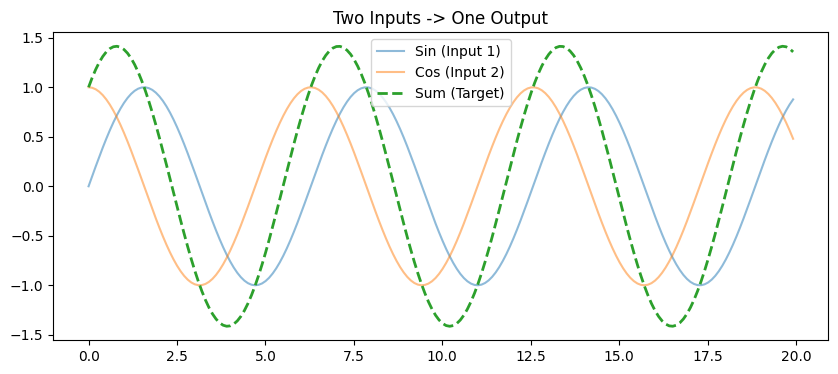

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate the Time Axis
x = np.linspace(0, 100, 1000)

# 2. Generate the Features (The inputs)
s1 = np.sin(x)       # Feature 1
s2 = np.cos(x)       # Feature 2

# 3. Generate the Target (The output we want to predict)
# Let's teach the LSTM to predict the SUM of the two signals
y = s1 + s2 

# 4. STACK the features together
# We need shape (1000, 2) -> 1000 time steps, 2 features each
data_input = np.column_stack((s1, s2))

print(f"Input Data Shape: {data_input.shape}")
print(f"Target Data Shape: {y.shape}")

# Visualization to see what we are doing
plt.figure(figsize=(10,4))
plt.plot(x[:200], s1[:200], label='Sin (Input 1)', alpha=0.5)
plt.plot(x[:200], s2[:200], label='Cos (Input 2)', alpha=0.5)
plt.plot(x[:200], y[:200], label='Sum (Target)', linestyle='--', linewidth=2)
plt.legend()
plt.title("Two Inputs -> One Output")
plt.show()

In [78]:
import torch

def create_multivariate_sequences(input_data, target_data, window_size):
    sequences = []
    labels = []
    
    # Loop through the data
    for i in range(len(input_data) - window_size):
        
        # 1. Grab the window of features (Sequence)
        # Shape: (Window_Size, 2) -> We grab both columns!
        seq = input_data[i : i + window_size]
        
        # 2. Grab the target value (Label)
        # Shape: (1)
        label = target_data[i + window_size]
        
        sequences.append(seq)
        labels.append(label)
        
    return np.array(sequences), np.array(labels)

# 1. Create the sequences
WINDOW_SIZE = 50
sequences, targets = create_multivariate_sequences(data_input, y, WINDOW_SIZE)

# 2. Convert to Tensors
# Note: No need to 'unsqueeze' the sequences anymore because they already have 2 dimensions (50, 2)
seqs = torch.from_numpy(sequences).float()
targets = torch.from_numpy(targets).float().view(-1, 1)

print("Input Shape:", seqs.shape)
print("Target Shape:", targets.shape)

Input Shape: torch.Size([950, 50, 2])
Target Shape: torch.Size([950, 1])


Training Multivariate LSTM...
Epoch: 0 | Loss: 0.99897
Epoch: 10 | Loss: 0.06462
Epoch: 20 | Loss: 0.02054
Epoch: 30 | Loss: 0.00500
Epoch: 40 | Loss: 0.00360
Epoch: 50 | Loss: 0.00121
Epoch: 60 | Loss: 0.00049
Epoch: 70 | Loss: 0.00026
Epoch: 80 | Loss: 0.00011
Epoch: 90 | Loss: 0.00004
Training Complete!


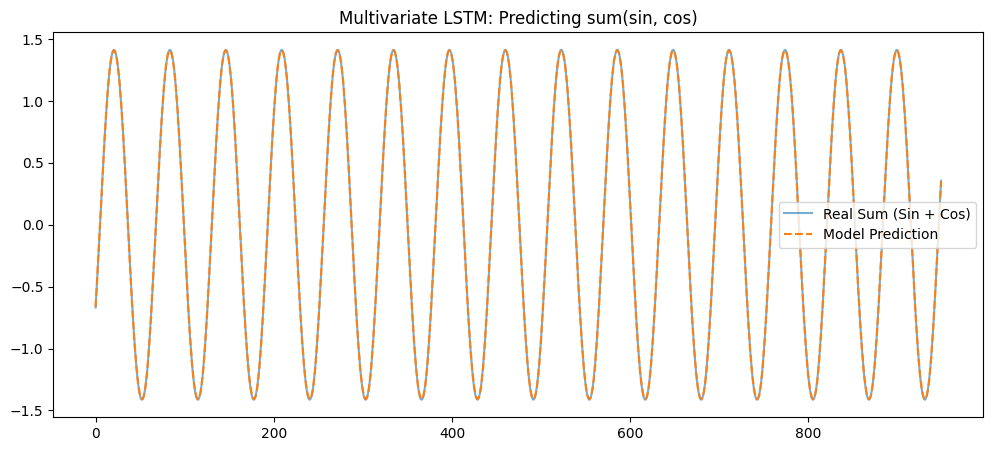

In [80]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DATA GENERATION (Multivariate) ---
x = np.linspace(0, 100, 1000)
s1 = np.sin(x)
s2 = np.cos(x)

# Feature Stack: (1000, 2)
data_input = np.column_stack((s1, s2))

# Target: The Sum (1000, 1)
y = s1 + s2

# Create Sequences
def create_multivariate_sequences(input_data, target_data, window_size):
    sequences = []
    labels = []
    for i in range(len(input_data) - window_size):
        seq = input_data[i : i + window_size] # Grab (50, 2)
        label = target_data[i + window_size]  # Grab (1)
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

WINDOW_SIZE = 50
sequences, targets = create_multivariate_sequences(data_input, y, WINDOW_SIZE)

# Convert to Tensors
seqs = torch.from_numpy(sequences).float()
targets = torch.from_numpy(targets).float().view(-1, 1)

# --- 2. MODEL DEFINITION ---
class MultiLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=60, output_size=1): # output_size fixed to 1
        super(MultiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_time_step = out[:, -1, :]
        prediction = self.linear(last_time_step)
        return prediction

# --- 3. TRAINING ---
model = MultiLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("Training Multivariate LSTM...")
epochs = 100
for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(seqs)
    loss = criterion(y_pred, targets)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f'Epoch: {i} | Loss: {loss.item():.5f}')

print("Training Complete!")

# --- 4. VISUALIZATION ---
# Let's see if it learned to ADD!
model.eval()
with torch.no_grad():
    preds = model(seqs).detach().numpy()

plt.figure(figsize=(12,5))
plt.plot(targets.numpy(), label='Real Sum (Sin + Cos)', alpha=0.6)
plt.plot(preds, label='Model Prediction', linestyle='--')
plt.title('Multivariate LSTM: Predicting sum(sin, cos)')
plt.legend()
plt.show()

Classification

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_classification_data(n_samples=200, seq_len=50):
    sequences = []
    labels = []
    
    for i in range(n_samples):
        # Create a time axis
        x = np.linspace(0, 10, seq_len)
        
        # Randomly choose: 0 (Sine) or 1 (Square)
        label = np.random.randint(0, 2)
        
        # Add some random noise/phase shift so they aren't all identical
        phase = np.random.rand() * 2 * np.pi
        
        if label == 0:
            # CLASS 0: Sine Wave (Normal)
            signal = np.sin(x + phase)
        else:
            # CLASS 1: Square Wave (Attack)
            # np.sign(sin) turns positive values to 1 and negative to -1 -> Square shape
            signal = np.sign(np.sin(x + phase))
            
        sequences.append(signal)
        labels.append(label)
        
    return np.array(sequences), np.array(labels)

# Generate data
# Shape: (200 samples, 50 time steps)
sequences_np, labels_np = generate_classification_data()

# Visual Check
plt.figure(figsize=(10,4))
plt.plot(sequences_np[0], label=f'Example 1 (Class {labels_np[0]})')
plt.plot(sequences_np[1], label=f'Example 2 (Class {labels_np[1]})')
plt.title("Sine (Class 0) vs Square (Class 1)")
plt.legend()
plt.show()

In [ ]:
sin = np.sin(x)
square = np.sign(sin)

In [92]:
def generate_classification_data(n_samples=200, seq_len=50):
    sequences = []
    labels = []
    
    for i in range(n_samples):
        # Create a time axis
        x = np.linspace(0, 10, seq_len)
        
        # Randomly choose: 0 (Sine) or 1 (Square)
        label = np.random.randint(0, 2)
        
        # Add some random noise/phase shift so they aren't all identical
        phase = np.random.rand() * 2 * np.pi
        
        if label == 0:
            # CLASS 0: Sine Wave (Normal)
            signal = np.sin(x + phase)
        else:
            # CLASS 1: Square Wave (Attack)
            # np.sign(sin) turns positive values to 1 and negative to -1 -> Square shape
            signal = np.sign(np.sin(x + phase))
            
        sequences.append(signal)
        labels.append(label)
        
    return np.array(sequences), np.array(labels)




sequences shape: (200, 50)
labels shape: (200,)


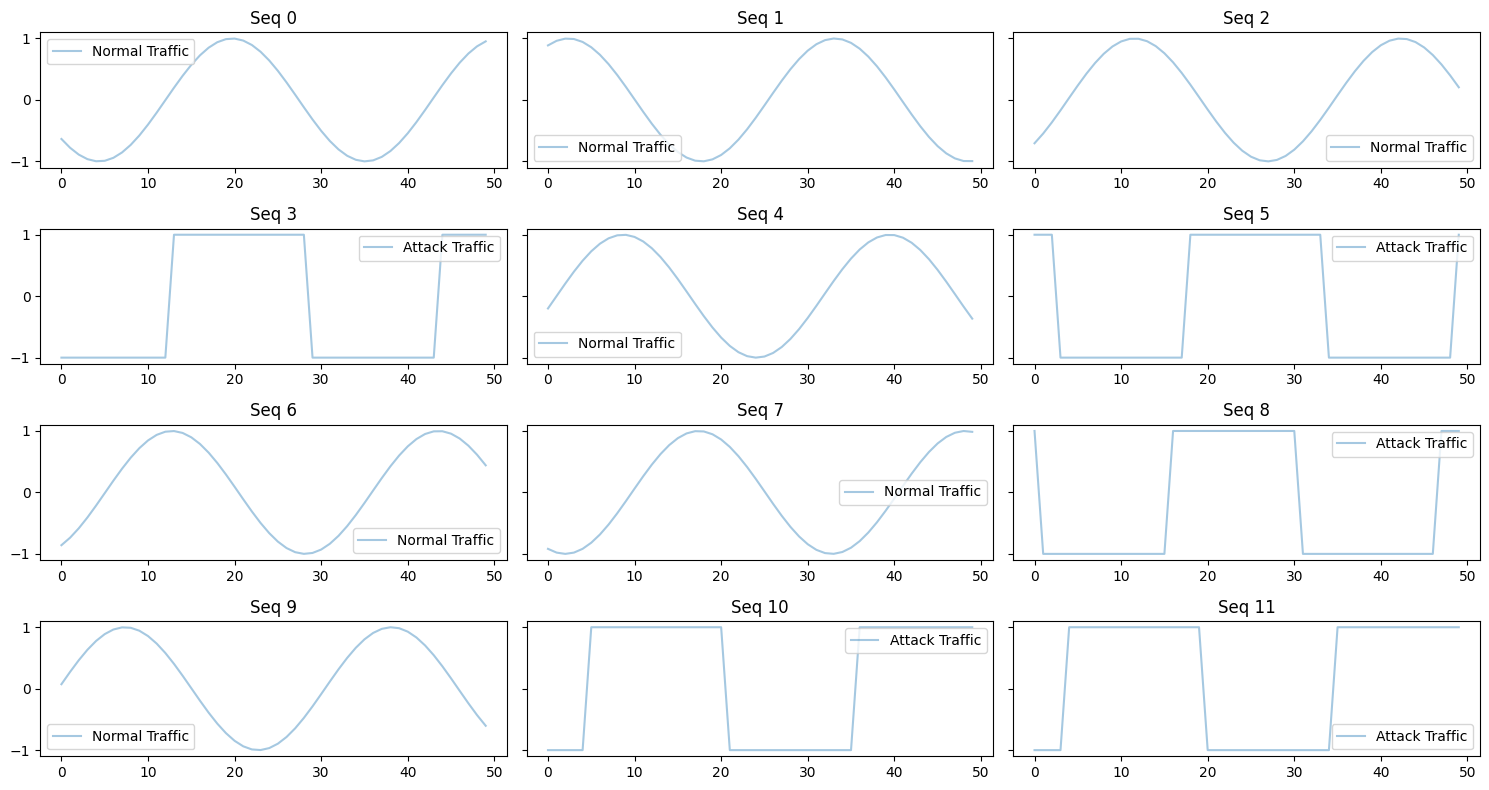

In [103]:
seqs, labels = generate_classification_data()

print("sequences shape:", seqs.shape)
print("labels shape:", labels.shape)

label_names = {0: 'Normal Traffic', 1: 'Attack Traffic'}

fig, axes = plt.subplots(4, 3, figsize=(15, 8), sharey=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(seqs[i], label=label_names[labels[i]], alpha=0.4)
    ax.set_title(f"Seq {i}")
    ax.legend()

plt.tight_layout()
plt.show()



In [104]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. PREPARE DATA
# Add the feature dimension: (200, 50) -> (200, 50, 1)
tensor_seqs = torch.from_numpy(seqs).float().unsqueeze(-1)

# Convert labels to Long (Integers) for CrossEntropy
tensor_labels = torch.from_numpy(labels).long()

# 2. DEFINE MODEL
class ClassifierLSTM(nn.Module):
    def __init__(self):
        super(ClassifierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.linear = nn.Linear(32, 2) # Output size 2 (Class 0 or Class 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_time_step = out[:, -1, :]
        logits = self.linear(last_time_step)
        return logits

model = ClassifierLSTM()

# 3. TRAIN
# Note: CrossEntropyLoss is used for classification categories
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("Training Security Guard...")
epochs = 500

for i in range(epochs):
    optimizer.zero_grad()
    outputs = model(tensor_seqs)
    loss = criterion(outputs, tensor_labels)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        # Check accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == tensor_labels).sum().item()
        acc = correct / len(tensor_labels)
        print(f'Epoch: {i} | Loss: {loss.item():.4f} | Accuracy: {acc*100:.1f}%')

print("Training Complete!")

Training Security Guard...
Epoch: 0 | Loss: 0.7081 | Accuracy: 42.0%
Epoch: 10 | Loss: 0.6598 | Accuracy: 63.5%
Epoch: 20 | Loss: 0.8006 | Accuracy: 54.0%
Epoch: 30 | Loss: 0.6853 | Accuracy: 58.0%
Epoch: 40 | Loss: 0.6802 | Accuracy: 58.0%
Epoch: 50 | Loss: 0.6790 | Accuracy: 58.0%
Epoch: 60 | Loss: 0.6785 | Accuracy: 58.0%
Epoch: 70 | Loss: 0.6776 | Accuracy: 58.0%
Epoch: 80 | Loss: 0.6764 | Accuracy: 58.0%
Epoch: 90 | Loss: 0.6740 | Accuracy: 58.0%
Epoch: 100 | Loss: 0.6688 | Accuracy: 67.0%
Epoch: 110 | Loss: 0.6559 | Accuracy: 67.0%
Epoch: 120 | Loss: 0.6170 | Accuracy: 66.5%
Epoch: 130 | Loss: 0.6283 | Accuracy: 65.5%
Epoch: 140 | Loss: 0.5295 | Accuracy: 77.5%
Epoch: 150 | Loss: 0.7010 | Accuracy: 58.0%
Epoch: 160 | Loss: 0.6792 | Accuracy: 58.0%
Epoch: 170 | Loss: 0.6793 | Accuracy: 58.0%
Epoch: 180 | Loss: 0.6793 | Accuracy: 58.0%
Epoch: 190 | Loss: 0.6792 | Accuracy: 58.0%
Epoch: 200 | Loss: 0.6790 | Accuracy: 58.0%
Epoch: 210 | Loss: 0.6788 | Accuracy: 58.0%
Epoch: 220 | Los

Final Test Accuracy: 100.0%


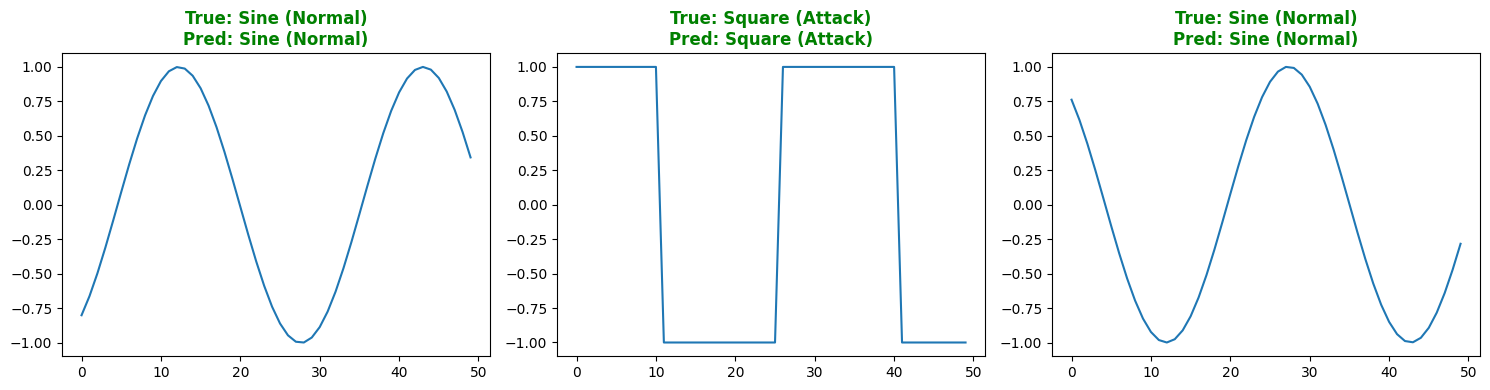

In [105]:
# 1. Generate NEW data (The Test Set)
# We use the same function, but this data was NOT used for training
test_seqs, test_labels = generate_classification_data(n_samples=50)

# Convert to Tensors
test_tensor_seqs = torch.from_numpy(test_seqs).float().unsqueeze(-1)
test_tensor_labels = torch.from_numpy(test_labels).long()

# 2. Evaluate
model.eval()
with torch.no_grad():
    test_outputs = model(test_tensor_seqs)
    _, test_preds = torch.max(test_outputs, 1)

# 3. Calculate Accuracy
correct = (test_preds == test_tensor_labels).sum().item()
test_accuracy = correct / len(test_tensor_labels)

print(f"Final Test Accuracy: {test_accuracy*100:.1f}%")

# 4. Visualize a few random test cases to prove it works
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, 50)
    ax.plot(test_seqs[idx])
    
    true_class = "Square (Attack)" if test_labels[idx] == 1 else "Sine (Normal)"
    pred_class = "Square (Attack)" if test_preds[idx] == 1 else "Sine (Normal)"
    
    # Title is Green if correct, Red if wrong
    color = 'green' if true_class == pred_class else 'red'
    ax.set_title(f"True: {true_class}\nPred: {pred_class}", color=color, fontweight='bold')

plt.tight_layout()
plt.show()